In [1]:
# Imports
from functions import (
    functional_form_PDE,
    kernel_smoothing,
    kernel_spatial_derivatives, 
    plot_comparison, 
)
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Data and Preprocessing
# u = np.load("data/bg.npy")
# system = 'bg'
u = np.load("data/diff.npy")
system = 'diff'
# u = np.load("data/ks_train.npy")
# system = 'ks'
u = np.squeeze(u)
if system=='bg' or system=='diff':
    x = np.linspace(-8, 8, 1000)
    t = np.linspace(0, 16, 1000)
elif system=='ks':
    x = np.linspace(0, 100, 1000)
    t = np.linspace(0, 100, 1000)

m, n = u.shape

In [3]:
# Noise
seed = 42
np.random.seed(seed)
u_std = np.std(u)
noise_percentage = 20
noise_std = (noise_percentage/100)*u_std
u_noisy = u + np.random.normal(scale=noise_std, size=(m, n))

In [4]:
l_values = [0.01, 0.1, 1, 5, 10]
c_values = [0.25, 0.5, 1, 5]
d_values = [1, 2, 3, 4, 5]
gamma_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

Best lengthscale value for smoothing: 1.0


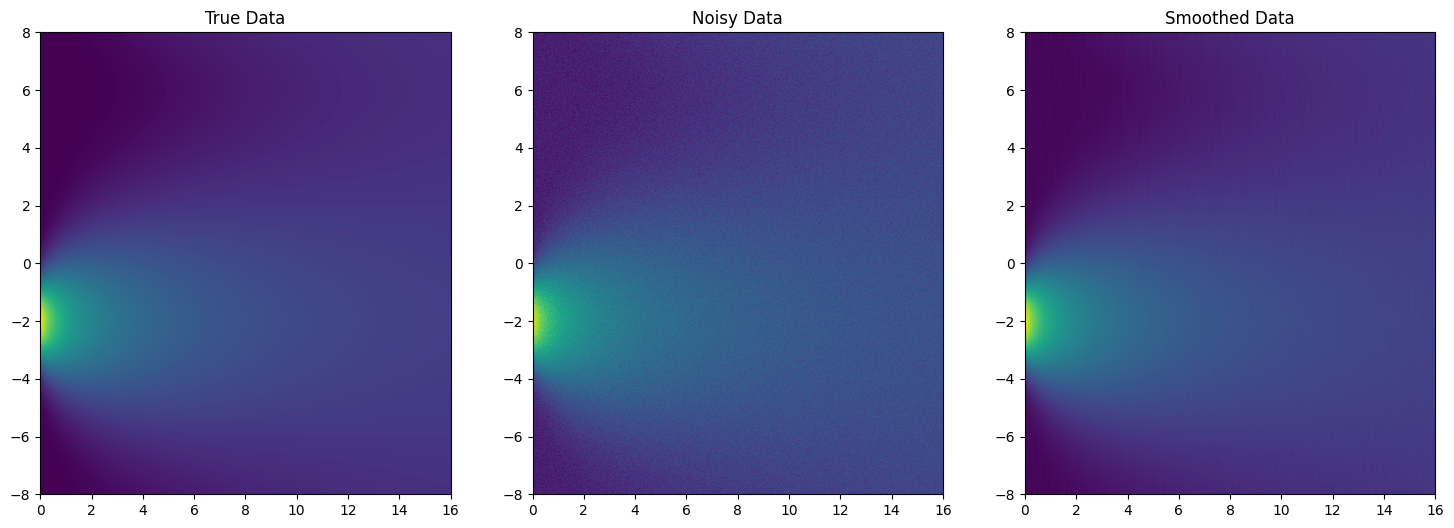

In [5]:
# RBF
U_mse_rbf = []
for l in l_values:
    kwargs = {'l': l}
    u_smooth = kernel_smoothing(u_noisy, x, kernel='rbf', **kwargs)
    mse = mean_squared_error(u, u_smooth)
    U_mse_rbf.append(mse)
    # plot_comparison(x, t, u=u, u_noisy=u_noisy, u_smooth=u_smooth)
    
U_rbf_data = pd.DataFrame(columns=(['l_value', 'mse']))
U_rbf_data['l_value'] = l_values
U_rbf_data['mse'] = U_mse_rbf

U_rbf_min_index = U_rbf_data['mse'].idxmin()
U_best_l = U_rbf_data.loc[U_rbf_min_index, 'l_value']
print(f"Best lengthscale value for smoothing: {U_best_l}")

U_best_rbf = {'l': U_best_l}
u_smooth_rbf = kernel_smoothing(u_noisy, x, kernel='rbf', **U_best_rbf)
U_fig_rbf, U_axs_rbf = plot_comparison(x, t, u=u, u_noisy=u_noisy, u_smooth=u_smooth_rbf)


Best coef0 value: 5.0
Best degree value: 5
Best gamma value: 0.05


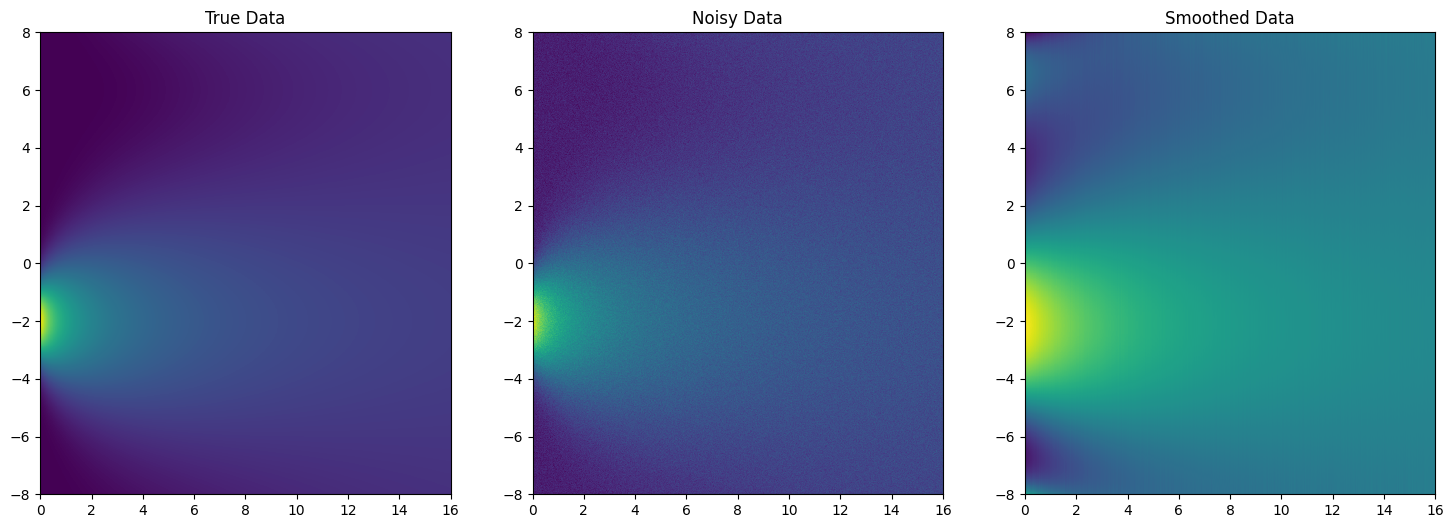

In [6]:
# Polynomial
U_mse_poly = []
U_combinations_poly = []
for gamma in gamma_values:
    for c in c_values:
        for d in d_values:
            kwargs = {'coef0': c, 'degree': d, 'gamma': gamma}
            u_smooth = kernel_smoothing(u_noisy, x, kernel='poly', **kwargs)
            mse = mean_squared_error(u, u_smooth)
            U_mse_poly.append(mse)
            U_combinations_poly.append((c, d, gamma))
            # plot_comparison(x, t, u=u, u_noisy=u_noisy, u_smooth=u_smooth)

U_poly_data = pd.DataFrame(U_combinations_poly, columns=['c_value', 'd_value', 'gamma_value'])
U_poly_data['mse'] = U_mse_poly

U_poly_min_index = U_poly_data['mse'].idxmin()
U_best_c = U_poly_data.loc[U_poly_min_index, 'c_value']
U_best_d = U_poly_data.loc[U_poly_min_index, 'd_value']
U_best_gamma = U_poly_data.loc[U_poly_min_index, 'gamma_value']
print(f"Best coef0 value: {U_best_c}")
print(f"Best degree value: {U_best_d}")
print(f"Best gamma value: {U_best_gamma}")

U_best_poly = {'coef0': U_best_c, 'degree': U_best_d, 'gamma': U_best_gamma}
u_smooth_poly = kernel_smoothing(u_noisy, x, kernel='poly', **U_best_poly)
U_fig_poly, U_axs_poly = plot_comparison(x, t, u=u, u_noisy=u_noisy, u_smooth=u_smooth_poly)

Best coef0 value: 0.25
Best gamma value: 0.25


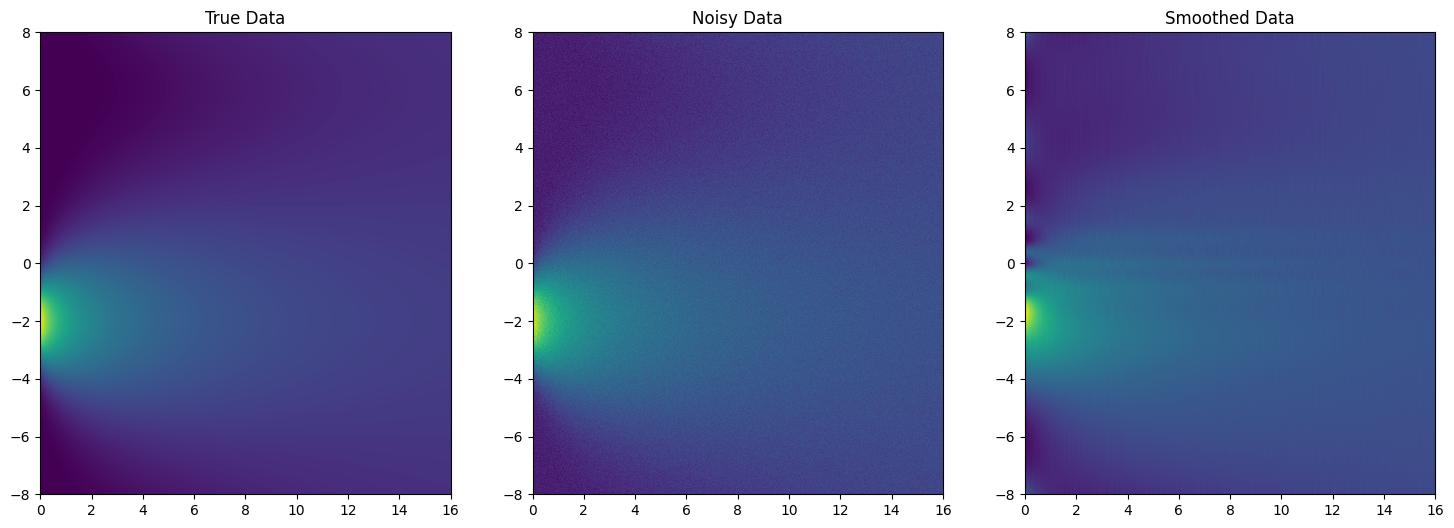

In [7]:
# Sigmoid
U_mse_sigmoid = []
U_combinations_sigmoid = []
for gamma in gamma_values:
    for c in c_values:
        kwargs = {'coef0': c, 'gamma': gamma}
        u_smooth = kernel_smoothing(u_noisy, x, kernel='sigmoid', **kwargs)
        mse = mean_squared_error(u, u_smooth)
        U_mse_sigmoid.append(mse)
        U_combinations_sigmoid.append((c, gamma))
        # plot_comparison(x, t, u=u, u_noisy=u_noisy, u_smooth=u_smooth)

U_sigmoid_data = pd.DataFrame(U_combinations_sigmoid, columns=['c_value', 'gamma_value'])
U_sigmoid_data['mse'] = U_mse_sigmoid

U_sigmoid_min_index = U_sigmoid_data['mse'].idxmin()
U_best_c_sigmoid = U_sigmoid_data.loc[U_sigmoid_min_index, 'c_value']
U_best_gamma_sigmoid = U_sigmoid_data.loc[U_sigmoid_min_index, 'c_value']
print(f"Best coef0 value: {U_best_c_sigmoid}")
print(f"Best gamma value: {U_best_gamma_sigmoid}")

U_best_sigmoid = {'coef0': U_best_c_sigmoid, 'gamma': U_best_gamma_sigmoid}
u_smooth_sigmoid = kernel_smoothing(u_noisy, x, kernel='sigmoid', **U_best_sigmoid)
U_fig_sigmoid, U_axs_sigmoid = plot_comparison(x, t, u=u, u_noisy=u_noisy, u_smooth=u_smooth_sigmoid)

In [8]:
# Diffusion
if system=='diff':
    rbf_derivatives = kernel_spatial_derivatives(x, x, u_noisy, kernel='rbf', order=2, **U_best_rbf)
    poly_derivatives = kernel_spatial_derivatives(x, x, u_noisy, kernel='poly', order=2, **U_best_poly)
    sigmoid_derivatives = kernel_spatial_derivatives(x, x, u_noisy, kernel='sigmoid', order=2, **U_best_sigmoid)


    X, Y = np.meshgrid(x, x)
    s_rbf = np.column_stack([X, u_smooth_rbf, rbf_derivatives['ux'], rbf_derivatives['uxx']])
    s_poly = np.column_stack([X, u_smooth_poly, poly_derivatives['ux'], poly_derivatives['uxx']])
    s_sigmoid = np.column_stack([X, u_smooth_sigmoid, sigmoid_derivatives['ux'], sigmoid_derivatives['uxx']])


    ut_rbf = - rbf_derivatives['uxx']
    ut_poly = - poly_derivatives['uxx']
    ut_sigmoid = - sigmoid_derivatives['uxx']

elif system=='bg':
    rbf_derivatives = kernel_spatial_derivatives(x, x, u_noisy, kernel='rbf', order=2, **U_best_rbf)
    poly_derivatives = kernel_spatial_derivatives(x, x, u_noisy, kernel='poly', order=2, **U_best_poly)
    sigmoid_derivatives = kernel_spatial_derivatives(x, x, u_noisy, kernel='sigmoid', order=2, **U_best_sigmoid)


    X, Y = np.meshgrid(x, x)
    s_rbf = np.column_stack([X, u_smooth_rbf, rbf_derivatives['ux'], rbf_derivatives['uxx']])
    s_poly = np.column_stack([X, u_smooth_poly, poly_derivatives['ux'], poly_derivatives['uxx']])
    s_sigmoid = np.column_stack([X, u_smooth_sigmoid, sigmoid_derivatives['ux'], sigmoid_derivatives['uxx']])


    ut_rbf = - 0.1 * rbf_derivatives['uxx'] + u_smooth_rbf * rbf_derivatives['ux']
    ut_poly = - 0.1 * poly_derivatives['uxx'] + u_smooth_poly * poly_derivatives['ux']
    ut_sigmoid = - 0.1 * sigmoid_derivatives['uxx'] + u_smooth_sigmoid * sigmoid_derivatives['ux']

elif system=='ks':
    rbf_derivatives = kernel_spatial_derivatives(x, x, u_noisy, kernel='rbf', order=4, **U_best_rbf)
    poly_derivatives = kernel_spatial_derivatives(x, x, u_noisy, kernel='poly', order=4, **U_best_poly)
    sigmoid_derivatives = kernel_spatial_derivatives(x, x, u_noisy, kernel='sigmoid', order=4, **U_best_sigmoid)


    X, Y = np.meshgrid(x, x)
    s_rbf = np.column_stack([X, u_smooth_rbf, rbf_derivatives['ux'], rbf_derivatives['uxx'],
                    rbf_derivatives['uxxx'], rbf_derivatives['uxxxx']])
    s_poly = np.column_stack([X, u_smooth_poly, poly_derivatives['ux'], poly_derivatives['uxx'],
                    poly_derivatives['uxxx'], poly_derivatives['uxxxx']])
    s_sigmoid = np.column_stack([X, u_smooth_sigmoid, sigmoid_derivatives['ux'], sigmoid_derivatives['uxx'],
                    sigmoid_derivatives['uxxx'], sigmoid_derivatives['uxxxx']])

    ut_rbf =  rbf_derivatives['uxx'] + rbf_derivatives['uxxxx'] + rbf_derivatives['ux'] * u_smooth_rbf
    ut_poly =  poly_derivatives['uxx'] + poly_derivatives['uxxxx'] + poly_derivatives['ux'] * u_smooth_poly
    ut_sigmoid =  sigmoid_derivatives['uxx'] + sigmoid_derivatives['uxxxx'] + sigmoid_derivatives['ux'] * u_smooth_sigmoid

In [9]:
# RBF
K_mse_rbf = []
for l in l_values:
    kwargs = {'l': l}
    P_rbf = functional_form_PDE(s_rbf, s_rbf, ut_rbf, kernel='rbf', **kwargs)
    mse = mean_squared_error(u, P_rbf)
    K_mse_rbf.append(mse)

K_rbf_data = pd.DataFrame(columns=(['l_value', 'mse']))
K_rbf_data['l_value'] = l_values
K_rbf_data['mse'] = K_mse_rbf

K_rbf_min_index = K_rbf_data['mse'].idxmin()
K_best_l = K_rbf_data.loc[K_rbf_min_index, 'l_value']
print(f"Best lengthscale value for P: {K_best_l}")

Best lengthscale value for P: 10.0


3.4172204172025734e-06


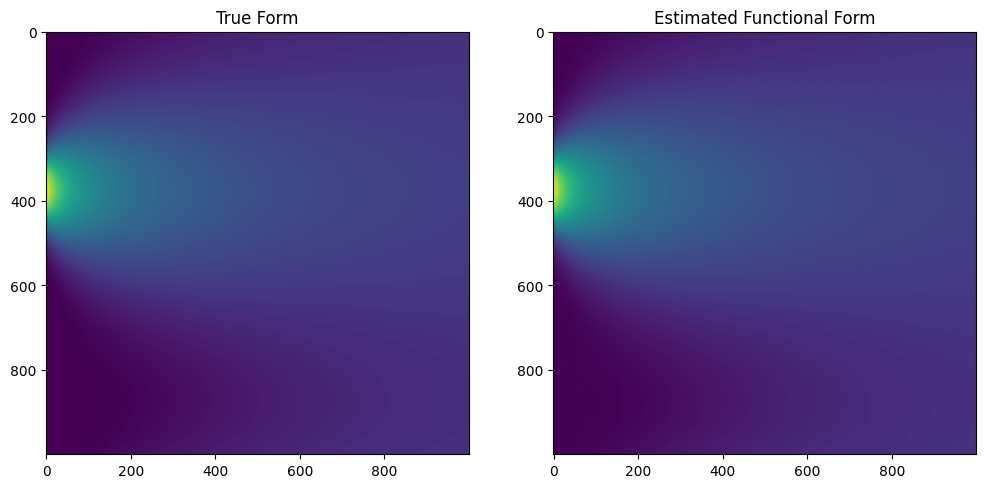

In [10]:
K_best_rbf = {'l': K_best_l}
best_P_rbf = functional_form_PDE(s_rbf, s_rbf, ut_rbf, kernel='rbf', **K_best_rbf)
print(mean_squared_error(u, best_P_rbf))
K_fig_rbf, K_axs_rbf = plt.subplots(1, 2, figsize=(12, 6))
K_axs_rbf[1].imshow(best_P_rbf)
K_axs_rbf[1].set(title="Estimated Functional Form")
K_axs_rbf[0].imshow(u)
K_axs_rbf[0].set(title="True Form")
plt.show()

In [11]:
# Polynomial
K_mse_poly = []
K_combinations_poly = []
for gamma in gamma_values:
    for c in c_values:
        for d in d_values:
            kwargs = {'coef0': c, 'degree': d, 'gamma': gamma}
            P_poly = functional_form_PDE(s_poly, s_poly, ut_poly, kernel='poly', **kwargs)
            mse = mean_squared_error(u, P_poly)
            K_mse_poly.append(mse)
            K_combinations_poly.append((c, d, gamma))

K_poly_data = pd.DataFrame(K_combinations_poly, columns=['c_value', 'd_value', 'gamma_value'])
K_poly_data['mse'] = K_mse_poly

K_poly_min_index = K_poly_data['mse'].idxmin()
K_best_c = K_poly_data.loc[K_poly_min_index, 'c_value']
K_best_d = U_poly_data.loc[K_poly_min_index, 'd_value']
K_best_gamma = K_poly_data.loc[K_poly_min_index, 'gamma_value']
print(f"Best coef0 value: {K_best_c}")
print(f"Best degree value: {K_best_d}")
print(f"Best gamma value: {K_best_gamma}")


d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:90: LinAlgWarning: Ill-conditioned matrix (rcond=1.03319e-16): result may not be accurate.
  P = K_test @ solve((K + 0.01 * np.eye(s.shape[0])), ut)
d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:90: LinAlgWarning: Ill-conditioned matrix (rcond=1.02527e-16): result may not be accurate.
  P = K_test @ solve((K + 0.01 * np.eye(s.shape[0])), ut)
d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:90: LinAlgWarning: Ill-conditioned matrix (rcond=1.0098e-16): result may not be accurate.
  P = K_test @ solve((K + 0.01 * np.eye(s.shape[0])), ut)
d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:90: LinAlgWarning: Ill-conditioned matrix (rcond=8.95284e-17): result may not be accur

Best coef0 value: 0.25
Best degree value: 1
Best gamma value: 0.0001


d:\UW\Studies\24 Spring\AMATH 563 Inferring Structure of Complex Systems\Project\AMATH563_PDERegression\functions.py:90: LinAlgWarning: Ill-conditioned matrix (rcond=5.10182e-24): result may not be accurate.
  P = K_test @ solve((K + 0.01 * np.eye(s.shape[0])), ut)


26.38093831652649


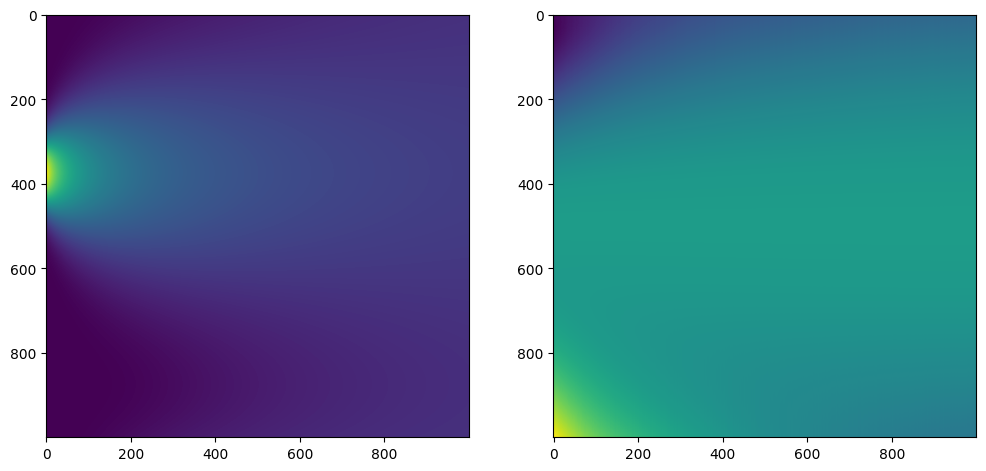

In [12]:
K_best_poly = {'coef0': K_best_c, 'degree': K_best_d, 'gamma': K_best_gamma}
best_P_poly = functional_form_PDE(s_poly, s_poly, ut_poly, kernel='poly', **K_best_poly)
print(mean_squared_error(u, best_P_poly))
K_fig_poly, K_axs_poly = plt.subplots(1, 2, figsize=(12, 6))
K_axs_poly[0].imshow(u)
K_axs_poly[1].imshow(best_P_poly)
plt.show()

In [13]:
# Sigmoid
K_mse_sigmoid = []
K_combinations_sigmoid = []
for gamma in gamma_values:
    for c in c_values:
        kwargs = {'coef0': c, 'gamma': gamma}
        P_sigmoid = functional_form_PDE(s_sigmoid, s_sigmoid, ut_sigmoid, kernel='sigmoid', **kwargs)
        mse = mean_squared_error(u, P_sigmoid)
        K_mse_sigmoid.append(mse)
        K_combinations_sigmoid.append((c, gamma))

K_sigmoid_data = pd.DataFrame(K_combinations_sigmoid, columns=['c_value', 'gamma_value'])
K_sigmoid_data['mse'] = K_mse_sigmoid

K_sigmoid_min_index = K_sigmoid_data['mse'].idxmin()
K_best_c_sigmoid = K_sigmoid_data.loc[K_sigmoid_min_index, 'c_value']
K_best_gamma_sigmoid = K_sigmoid_data.loc[K_sigmoid_min_index, 'c_value']
print(f"Best coef0 value: {K_best_c_sigmoid}")
print(f"Best gamma value: {K_best_gamma_sigmoid}")

Best coef0 value: 0.25
Best gamma value: 0.25


0.3725580732812458


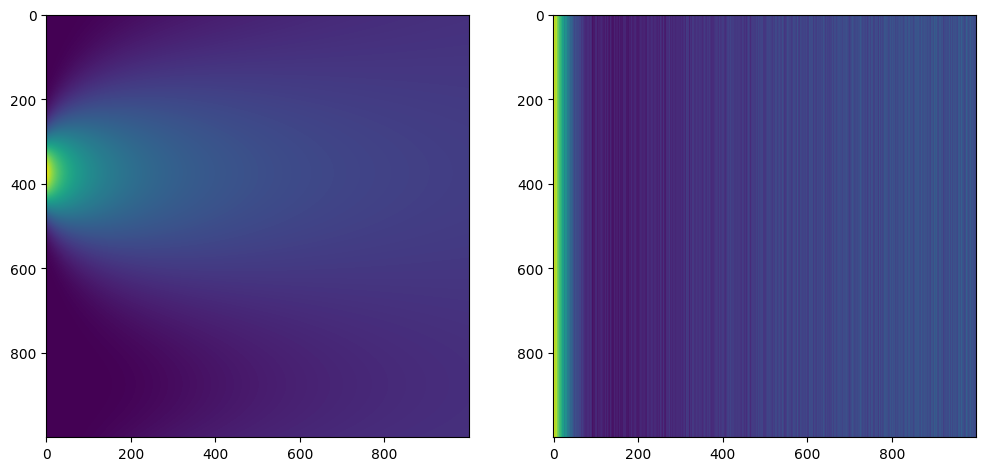

In [14]:
K_best_sigmoid = {'coef0': K_best_c_sigmoid, 'gamma': K_best_gamma_sigmoid}
best_P_sigmoid = functional_form_PDE(s_sigmoid, s_sigmoid, ut_sigmoid, kernel='sigmoid', **K_best_sigmoid)
print(mean_squared_error(u, best_P_sigmoid))
K_fig_sigmoid, K_axs_sigmoid = plt.subplots(1, 2, figsize=(12, 6))
K_axs_sigmoid[0].imshow(u)
K_axs_sigmoid[1].imshow(best_P_sigmoid)
plt.show()

In [15]:
if system=='bg':
    U_rbf_data.to_csv('results/burgers/U_rbf.csv')
    U_poly_data.to_csv('results/burgers/U_poly.csv')
    U_sigmoid_data.to_csv('results/burgers/U_sigmoid.csv')
    K_rbf_data.to_csv('results/burgers/K_rbf.csv')
    K_poly_data.to_csv('results/burgers/K_poly.csv')
    K_sigmoid_data.to_csv('results/burgers/K_sigmoid.csv')
    U_fig_rbf.savefig('results/burgers/U_rbf.png')
    U_fig_poly.savefig('results/burgers/U_poly.png')
    U_fig_sigmoid.savefig('results/burgers/U_sigmoid.png')
    K_fig_rbf.savefig('results/burgers/K_rbf.png')
    K_fig_poly.savefig('results/burgers/K_poly.png')
    K_fig_sigmoid.savefig('results/burgers/K_sigmoid.png')
elif system=='diff':
    U_rbf_data.to_csv('results/diffusion/U_rbf.csv')
    U_poly_data.to_csv('results/diffusion/U_poly.csv')
    U_sigmoid_data.to_csv('results/diffusion/U_sigmoid.csv')
    K_rbf_data.to_csv('results/diffusion/K_rbf.csv')
    K_poly_data.to_csv('results/diffusion/K_poly.csv')
    K_sigmoid_data.to_csv('results/diffusion/K_sigmoid.csv')
    U_fig_rbf.savefig('results/diffusion/U_rbf.png')
    U_fig_poly.savefig('results/diffusion/U_poly.png')
    U_fig_sigmoid.savefig('results/diffusion/U_sigmoid.png')
    K_fig_rbf.savefig('results/diffusion/K_rbf.png')
    K_fig_poly.savefig('results/diffusion/K_poly.png')
    K_fig_sigmoid.savefig('results/diffusion/K_sigmoid.png')
elif system =='ks':
    U_rbf_data.to_csv('results/ks/U_rbf.csv')
    U_poly_data.to_csv('results/ks/U_poly.csv')
    U_sigmoid_data.to_csv('results/ks/U_sigmoid.csv')
    K_rbf_data.to_csv('results/ks/K_rbf.csv')
    K_poly_data.to_csv('results/ks/K_poly.csv')
    K_sigmoid_data.to_csv('results/ks/K_sigmoid.csv')
    U_fig_rbf.savefig('results/ks/U_rbf.png')
    U_fig_poly.savefig('results/ks/U_poly.png')
    U_fig_sigmoid.savefig('results/ks/U_sigmoid.png')
    K_fig_rbf.savefig('results/ks/K_rbf.png')
    K_fig_poly.savefig('results/ks/K_poly.png')
    K_fig_sigmoid.savefig('results/ks/K_sigmoid.png')